# Script Generator for the Office

In this notebook we'll train a character level LSTM, to generate script like text.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.model_selection import train_test_split

## Data Preprocessing

We'll now load the dataset and preprocess it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

with open('/content/drive/MyDrive/office_script_clean.txt') as f:
  data = f.read()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
vocab = sorted(set(data))
vocab_size = len(vocab)
total_chars = len(data)
ctx_length = 60
print("Vocab Size", vocab_size)
print("Total Characters: ", total_chars)
print("Context Length: ", ctx_length)

Vocab Size 72
Total Characters:  3427466
Context Length:  60


## Character Tokenizer

We'll now build a tokenizer for characters and encode the data.

In [ ]:
char_idx = {u:i for i, u in enumerate(vocab)}
idx_char = np.array(vocab)

encoded_data = np.array([char_idx[i] for i in data])

## Dataset Creation

We'll now create sequences for our LSTM and split it into train and test.

In [ ]:
def create_sequence(data, ctx_length):
  X, y = [], []
  for i in range(len(data) - ctx_length):
    X.append(data[i:i+ctx_length])
    y.append(data[i+ctx_length])
  return np.array(X), np.array(y)

In [ ]:
X, y = create_sequence(encoded_data, ctx_length)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

## Model Building

We'll now proceed to build our model.

In [ ]:
model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(256, return_sequences=True),
    LSTM(256),
    Dense(vocab_size, activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128
)

Epoch 1/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 556s 23ms/step - loss: 1.6614 - val_loss: 1.2695
Epoch 2/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 548s 23ms/step - loss: 1.2401 - val_loss: 1.2154
Epoch 3/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 549s 23ms/step - loss: 1.1908 - val_loss: 1.1979
Epoch 4/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 549s 23ms/step - loss: 1.1671 - val_loss: 1.1862
Epoch 5/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 551s 23ms/step - loss: 1.1536 - val_loss: 1.1807
Epoch 6/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 550s 23ms/step - loss: 1.1474 - val_loss: 1.1803
Epoch 7/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 548s 23ms/step - loss: 1.1408 - val_loss: 1.1755
Epoch 8/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 548s 23ms/step - loss: 1.1373 - val_loss: 1.1744
Epoch 9/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 551s 23ms/step - loss: 1.1352 - val_loss: 1.1744
Epoch 10/10
24099/24099 ━━━━━━━━━━━━━━━━━━━━ 550s 23ms/step - loss: 1.1333 - val_loss: 1.1746


In [ ]:
def perplexity(loss):
    return np.exp(loss)

train_ppl = perplexity(history.history['loss'][-1])
val_ppl = perplexity(history.history['val_loss'][-1])

print("Train Perplexity:", train_ppl)
print("Validation Perplexity:", val_ppl)


Train Perplexity: 3.1214891949334693
Validation Perplexity: 3.236812077347321


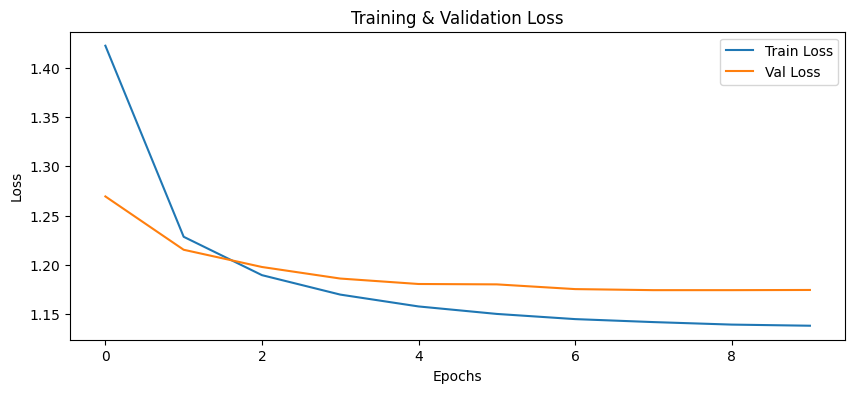

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


## Text Generation

Now we'll use our model to generate some scripts at different temperatures.

In [ ]:
def temperature_sampling(preds, temp=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds + 1e-8) / temp
  preds_exp = np.exp(preds)
  probs = preds_exp / np.sum(preds_exp)
  return np.random.choice(len(probs), p=probs)

In [ ]:
def generate_script(seed_text, temperature=1.0, num_tokens=300):
  generated = seed_text

  for _ in range(num_tokens):
    input = [char_idx[i] for i in generated[-ctx_length:]]
    input = tf.expand_dims(input, 0)

    preds = model.predict(input, verbose=0)[0]
    next_char_idx = temperature_sampling(preds, temperature)

    generated += idx_char[next_char_idx]
  return generated

Temperature = **0.3**

In [ ]:
print(generate_script("Jim", 0.3, 1000))

Jims in the back.
Jim: What are you doing?
Dwight: I don't know what you want to go to the work of a date and I just have a car. So what is he doing in the company job in the conference room that you want to do that to me and I will see you to the group of the way to take a lot of things that you want to go.
Andy: I don't know what that was hard to see that card.
Andy: Oh, I have to go to the face.
Jim: Yeah, that's a good time. I don't know what that makes a second.
Michael: Okay.
Michael: Okay.
Michael: I don't know what they were at the paper for the whole time.
Jim: Oh, good to see you later.
Dwight:  Oh, okay. I want to see the surrountic of the money.
Dwight: I don't know. I don't know.
Andy: Well, I don't know what you want to go to the baby.
Dwight: Oh, that's a lot of things about the profit. I don't know how you can leave a lot of things to the rest of the way, and I think I am the stuff. I don't know what you want to see that out of the thing.
Dwight: I don't know what they 

Temperature = **0.7**

In [ ]:
print(generate_script("Jim", 0.7, 1000))

Jims is supposed to take you to me. And I think it was a project of a burning.
Clark: I didn't know.
Pam: No. My wife is the warehouse, of course. Oh, the time are comminations.
Michael: I am going to let you start a food that the crazy. I have to be undernote.
Dwight: Oh, no, no, no, no, no, no. It's a desk?
Donna: Eye. It's the best friend that I should come and I want. I was being success in the warehouse matters on your beauty to be a second.
Jim: Easy, welcome though, right?
Andy: I don't know.
Michael: Oh, God. It's me.
Dwight:  I don't know what the where was here. I will have to have some assemble. I did.
Jim: You own the man the good time was scuped the matter I have a stupid depeced file.
Michael: It's the best talk just...
Dwight: Dwight, you don't know how this whole seat is draworche all town.
Pam: Are you sure something else come back in the party?
Pam: Uh, uh, yeah.
Jan: No I told you.
Ryan: I have a bit of the ideas for me to rehate this elephant. I mean we are not a fe

Temperature = **1.0**

In [ ]:
print(generate_script("Jim", 1.0, 1000))

Jim Clut Dwight.
Dwight: Oh, good!
Ryan: Hey... Uh, wait, Holly
Kevin: Hello. Excuse me walking my daughter, two. I don't know how you said you should be sorry. Leaving on call!
Jan: Um the baseball, actually Floridabs.
Jo.
Erin: Why do you look release? 
Esther: Kevin that ever take a great thing? And they're acceptions and Phyllis Bernard downer.
Dwight: Sorry. Yay. Okay.
Jim: I bear it in fun.
Jim:  To Hockea. Wha.
Dwight: My old Farmer or he called you, Sense that course.
Dwight: You know what you need to be email I'm going to be able.
Pothewast 2: Look at it from must been a refuse.
Jim: Ha ha on his execut you ten untrit because I don't miss your uncool. I don't think that  I am shipes.
Dwight: I like that in my sick.
Kevin: Any other percent saying?
Jim: Right my hotel carefully!! Too.
Kevin: At this phone ship babys. For the thisdernive. Wait it's not his very rusinnack.
Dwight:  Mr. Phyllis, this is all shugh, right?
Angela: But we are harded by his boss.
Jim:  What do you... 

## Conclusion

As we can see that we achieved perplexity scores of 3.1 on training set and 3.2 on the validation set which are in accpeted ranges of 2.5 to 3.5.

The best sample was achieved on setting temperature to 0.7 which was a good blend of non repeatation and sensible text. At 0.3, the model tended to get very repetitive whereas it produced almost unrecognizable text on 1.0 temperature.

Since this was a simple character level LSTM, we can see from our results that although this model (which took 1.5 hours to train) can construct words, follow punctutaion, and make it in a script format of `character: dialogue`.

Although due to the same reason, it lacked inherent understanding of the meaning of words and generated unmeaningful sentences and could barely grasp repeatative rules of grammar.